In [1]:
# Importing required libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the dataset
data = pd.read_csv('synthetic_sensor_data.csv')
data.head()

,Timestamp,Temperature,Anomaly,Location
0,2024-06-01 19:50:28,24.476332,0,SensorB
1,2024-06-01 19:50:28,18.253966,0,SensorA
2,2024-06-01 19:50:28,14.953520,0,SensorB
3,2024-06-01 19:50:28,17.667181,0,SensorA
4,2024-06-01 19:50:28,17.079826,0,SensorA


In [3]:
data.shape

(10000, 4)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Timestamp    10000 non-null  object 
 1   Temperature  10000 non-null  float64
 2   Anomaly      10000 non-null  int64  
 3   Location     6704 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 312.6+ KB


In [5]:
data.columns

Index(['Timestamp', 'Temperature', 'Anomaly', 'Location'], dtype='object')

In [6]:
data.drop(columns=['Timestamp','Location'],inplace=True)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  10000 non-null  float64
 1   Anomaly      10000 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 156.4 KB


In [8]:
data.isnull().sum()

Temperature    0
Anomaly        0
dtype: int64

In [9]:
data.head()

,Temperature,Anomaly
0,24.476332,0
1,18.253966,0
2,14.953520,0
3,17.667181,0
4,17.079826,0


In [10]:
x = data[['Temperature']]
y = data['Anomaly']

In [11]:
# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42,stratify=y)

In [12]:
# Handle class imbalance using SMOTEENN
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# smote_enn = SMOTEENN(random_state=42)
# x_resampled, y_resampled = smote_enn.fit_resample(x, y)

smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Balance ratio: minority is 50% of majority
x_smote, y_smote = smote.fit_resample(x_train, y_train)

undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)  # 1:1 balance
x_resampled, y_resampled = undersampler.fit_resample(x_smote, y_smote)

In [13]:
len(y_resampled)

7816

In [14]:
len(x_resampled)

7816

In [15]:
len(y_test)

2000

In [16]:
y_resampled.value_counts()

Anomaly
0    3908
1    3908
Name: count, dtype: int64

In [17]:
y_train.value_counts()

Anomaly
0    7817
1     183
Name: count, dtype: int64

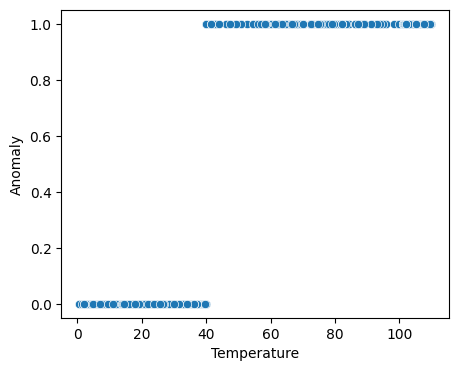

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,4))
sns.scatterplot(x='Temperature',y='Anomaly',data=data)
plt.show()

In [19]:
x_resampled.shape,x_test.shape,y_resampled.shape,y_test.shape

((7816, 1), (2000, 1), (7816,), (2000,))

In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(x_resampled,y_resampled)

LogisticRegression(class_weight='balanced', random_state=42)

In [22]:
model.score(x_test,y_test)

0.9995

In [23]:
model.score(x_resampled,y_resampled)

0.9994882292732856

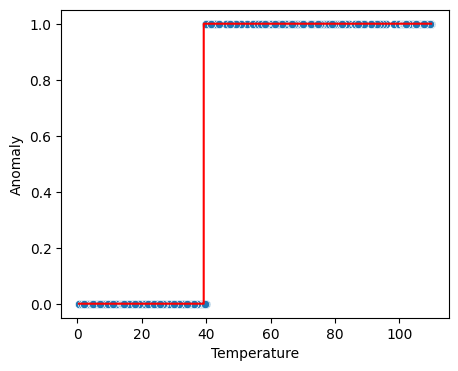

In [24]:
plt.figure(figsize=(5,4))
sns.scatterplot(x='Temperature',y='Anomaly',data=data)
sns.lineplot(x='Temperature',y=model.predict(x),data=data,color='red')
plt.show()

In [25]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve)

import matplotlib.pyplot as plt

In [26]:
# Predict on test set
y_pred = model.predict(x_test)
y_prob = model.predict_proba(x_test)[:, 1]  # Probabilities for the positive class

In [27]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[1953    1]
 [   0   46]]


In [28]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1954
           1       0.98      1.00      0.99        46

    accuracy                           1.00      2000
   macro avg       0.99      1.00      0.99      2000
weighted avg       1.00      1.00      1.00      2000



In [29]:
# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")

Accuracy: 1.00
Precision: 0.98
Recall: 1.00
F1-Score: 0.99
ROC-AUC: 1.00


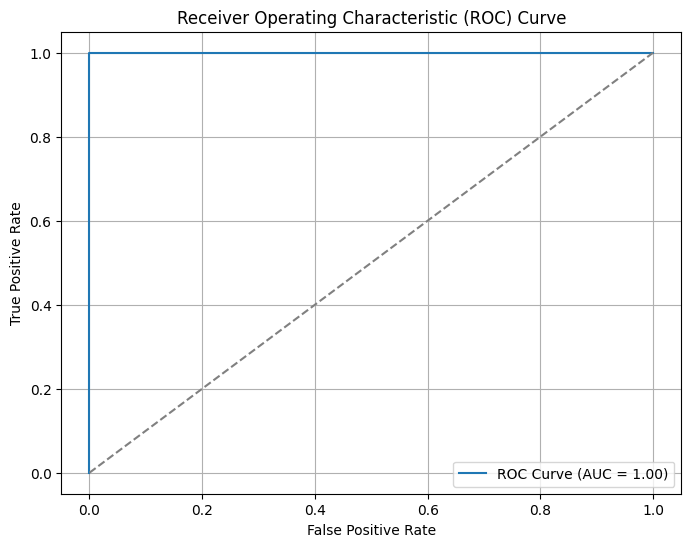

In [30]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.grid()
plt.show()

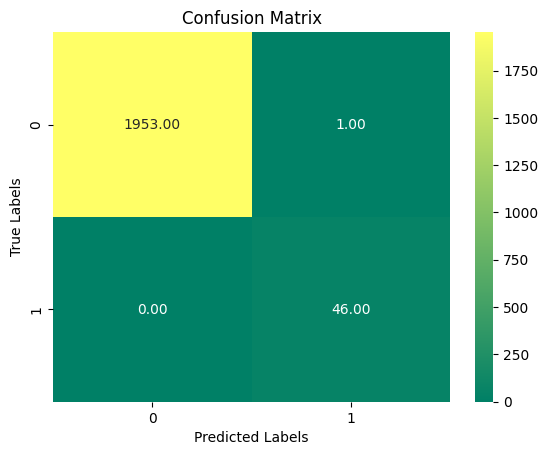

In [45]:
# Create a heatmap
sns.heatmap(cm, annot=True, fmt='.2f', cmap='summer')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('Confusion Matrix.png')
plt.show()

In [35]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, x, y, cv=5, scoring="f1")
print(f"Cross-Validated F1 Scores: {scores}")
print(f"Mean F1 Score: {scores.mean():.2f}")

Cross-Validated F1 Scores: [1.         0.9787234  0.98924731 0.98924731 0.96842105]
Mean F1 Score: 0.99


In [36]:
# Training set performance
y_train_pred = model.predict(x_resampled)
train_accuracy = accuracy_score(y_resampled, y_train_pred)
print(f"Training Accuracy: {train_accuracy}")

# Test set performance
y_test_pred = model.predict(x_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 0.9994882292732856
Test Accuracy: 0.9995


In [37]:
from joblib import dump

# Save the model
dump(model, 'logistic_regression_model.joblib')

print("Model saved as 'logistic_regression_model.joblib'")

Model saved as 'logistic_regression_model.joblib'


In [38]:
from joblib import load

# Load the model
loaded_model = load('logistic_regression_model.joblib')

# Use the loaded model for predictions
y_pred = loaded_model.predict(x_test)
print("Predictions from the loaded model:", y_pred)

Predictions from the loaded model: [1 0 0 ... 0 0 0]
